## Markov Chain on series of events

We wanted to create a Markov Chain for the series of possible events for tourists on a fictional city. See the image below for reference

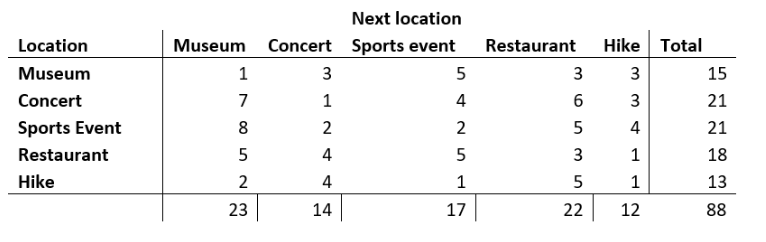

With the information above, we can start to analyze the probabilities of a tourist going to an event B given they were event A, thus a Markov Chain


# Conditional Probability Table

|              	| Museum 	| Concert 	| Sports Event 	| Restaurant 	| Hike 	|
|--------------	|--------	|---------	|--------------	|------------	|------	|
| Museum       	| 0.07   	| 0.20    	| 0.33         	| 0.20       	| 0.20 	|
| Concert      	| 0.33   	| 0.05    	| 0.19         	| 0.29       	| 0.14 	|
| Sports Event 	| 0.38   	| 0.10    	| 0.10         	| 0.24       	| 0.19 	|
| Restaurant   	| 0.28   	| 0.22    	| 0.28         	| 0.17       	| 0.06 	|
| Hike         	| 0.15   	| 0.31    	| 0.08         	| 0.38       	| 0.08 	|

# Import Data, Generate Transition Matrix

In [20]:
import pandas as pd

data = {
    'Museum': [1, 3, 5, 3, 3],
    'Concert': [7, 1, 4, 6, 3],
    'Sports Event': [8, 2, 2, 5, 4],
    'Restaurant': [5, 4, 5, 3, 1],
    'Hike': [2, 4, 1, 5, 1]
}

df = pd.DataFrame(data, index=['Museum', 'Concert', 'Sports Event', 'Restaurant', 'Hike']).T

totals = df.sum(axis=1)
totals

Museum          15
Concert         21
Sports Event    21
Restaurant      18
Hike            13
dtype: int64

### Get transition matrix values

In [21]:
transition_matrix = df.divide(totals, axis=0)
print(transition_matrix.round(2))


              Museum  Concert  Sports Event  Restaurant  Hike
Museum          0.07     0.20          0.33        0.20  0.20
Concert         0.33     0.05          0.19        0.29  0.14
Sports Event    0.38     0.10          0.10        0.24  0.19
Restaurant      0.28     0.22          0.28        0.17  0.06
Hike            0.15     0.31          0.08        0.38  0.08


# Generate graph and display

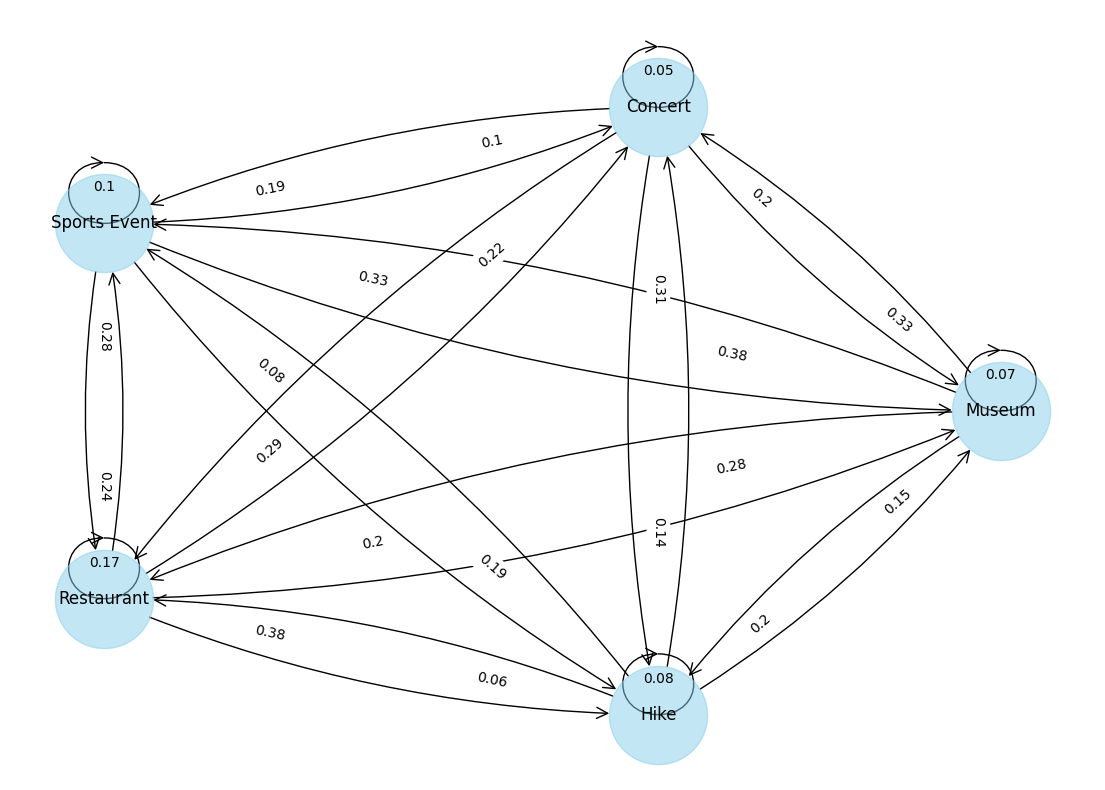

In [22]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph()

for activity in transition_matrix.columns:
    G.add_node(activity)

for i, row in transition_matrix.iterrows():
    for col in transition_matrix.columns:
            G.add_edge(i, col, weight=row[col])

pos = nx.circular_layout(G)
plt.figure(figsize=(14, 10))

nx.draw_networkx_nodes(G, pos, node_size=5000, node_color='skyblue', alpha=0.5)

edges = nx.draw_networkx_edges(G, pos, arrowstyle='->', node_size=5000, arrowsize=20, edge_color='black', 
                               connectionstyle='arc3,rad=0.1')

nx.draw_networkx_labels(G, pos, font_size=12, font_family='sans-serif')

edge_labels = dict([((u, v,), round(d['weight'], 2)) for u, v, d in G.edges(data=True)])

# self loop edges aren't getting displayed so manually add it
for (u, v), label in edge_labels.items():
    if u == v:
        x, y = pos[u]
        label_pos = (x, y + 0.1)
        plt.text(label_pos[0], label_pos[1], s=label, horizontalalignment='center')
    else:
        nx.draw_networkx_edge_labels(G, pos, edge_labels={ (u,v): label }, label_pos=0.3)

plt.axis('off')
plt.show()

# Solve for the Steady-State Probabilities

Solve for the problem πA=π, where A is P, our transition matrix. Essentially, we are looking for the eigenvector of the transition matrix P that corresponds to an eigenvalue of 1.

In the code below, we do not directly solve the eigenvalue problem but instead use the property of Markov chains that allows us to repeatedly apply the transition matrix to an (or any) initial disitrubtion, which eventually converges to the steady-state distribution.

In [23]:
import numpy as np
import pandas as pd

P = transition_matrix.values

# Start with an initial distribution pi
pi = np.full((P.shape[0],), 1 / P.shape[0])

### Display distribution vector

In [24]:
pi

array([0.2, 0.2, 0.2, 0.2, 0.2])

### Solve

In [25]:
threshold = 1e-6 # set a very low threshold
iterations = 0
delta = 1  # change in pi

# While our change in pi is less than our threshold, 
# repeatedly apply P to the current dist. of pi to get a new dist pi_new
# Then, store the distribution change in pi as delta
while delta > threshold:
    pi_new = pi @ P  # Matrix multiplication of pi by P
    delta = np.linalg.norm(pi_new - pi)  # Calculate the change in the probabilities
    pi = pi_new
    iterations += 1

# pi now holds the steady-state distribution, and iterations tells us how many steps it took to get there

### How many iterations did it take for us to get to the steady-state probabilities?

In [26]:
iterations

11

### Print the steady-state distribution defined by P

In [27]:
pi

array([0.24117053, 0.17183476, 0.21032664, 0.23997717, 0.1366909 ])

### Confirm that pi * P = pi

In [28]:
pi_P = np.dot(pi, P)
print(f"pi*P = {pi_P}")
print(f"pi = {pi}")

pi*P = [0.24117042 0.17183482 0.21032673 0.23997714 0.1366909 ]
pi = [0.24117053 0.17183476 0.21032664 0.23997717 0.1366909 ]


### Confirm that the sum of elements of pi is = 1

The sum of probabilities for all possible outcomes should be equal to 1.

In [29]:
np.sum(pi)

1.0

# Illustrate the Steady-State Distribution

The steady-state probabilities for each state - each activity - tell us the popularity of each activitity and help us understand the likelihood that a large proportion of tourists would choose the activity as their next visit. Boiled down, its a 'snapshot' predictive model.

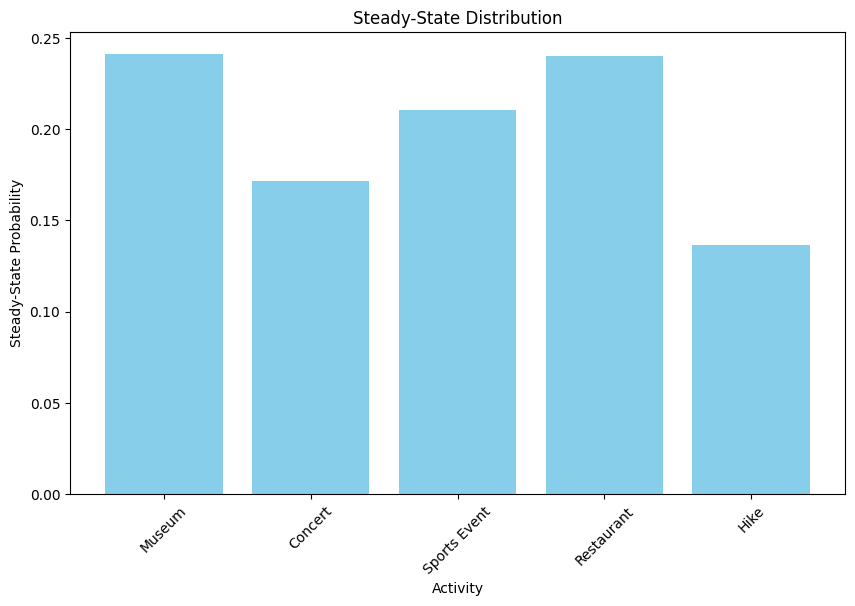

In [30]:
plt.figure(figsize=(10, 6))
states_labels = ['Museum', 'Concert', 'Sports Event', 'Restaurant', 'Hike']
plt.bar(states_labels, pi, color='skyblue')
plt.xlabel('Activity')
plt.ylabel('Steady-State Probability')
plt.title('Steady-State Distribution')
plt.xticks(rotation=45)
plt.show()


# In tour of only three locations, how likely is a tourist to attend a concert, go on a hike, then eat at a restaurant?

The likelihood of a tourist attending a concert, then going on a hike, and then finally eating at a restaurant is the product of transition probabilities for each step of the sequence.

This is based on the Markov property where the probability of transitioning to a future state (Activity) depends **only on the current state** and not on the sequence of events that precede it.

### Remember back to our transition matrix:

So, we find the probability by calculating:

P(Concert -> Hike) * P(Hike -> Restaurant)

In [31]:
stylized_matrix = transition_matrix

probability = stylized_matrix['Concert']['Hike'] * stylized_matrix['Hike']['Restaurant']
print(probability)

0.017094017094017096


So Given the calculations above we see that the probability of a tourist attending a concert, then going on a hike, then going to eat at a restaurant is 1.71%

# What is the likelihood of visiting any of the locations as the fifth step?

Using the following approach:

Since there are five possible locations to start the tour and the starting state distribution is uniform, the starting *probability vector*, *spv = [0.2, 0.2, 0.2, 0.2, 0.2].*

We need to compute the fifth entry of the starting probability vector by multiplying the *spv* by the fifth power of the transition matrix.

So, we first define *spv* and then raise P to the fifth power. Finally, we multiply *spv* by *P^5*.

In [32]:
spv = np.array([0.2, 0.2, 0.2, 0.2, 0.2])

P_5 = np.linalg.matrix_power(P, 5)

activities = ["Museum", "Concert", "Sports Event", "Restaurant", "Hike"]

fifth_step_probabilities = np.dot(spv, P_5)

fifths = pd.Series(fifth_step_probabilities, index=activities)

fifths_percents = fifths.apply(lambda x: f"{x:.2%}")

### Probability for visiting each Activity as the fifth step:

In [33]:
fifths_percents

Museum          24.13%
Concert         17.18%
Sports Event    21.03%
Restaurant      24.00%
Hike            13.67%
dtype: object

### MCMC Question
Can the transition probabilities between touristic events be accurately estimated using a Markov Chain Monte Carlo model?

In [5]:
import pymc as pm
import numpy as np

# Example data: 
n_tourists = 100
extend_stay = np.random.binomial(1, p=0.5, size=n_tourists)  # Random binary data for stay extension
visited_locations = np.random.poisson(lam=2, size=n_tourists)  # Random count data for locations visited

with pm.Model() as model:
    # Prior distributions for α and β
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Normal('beta', mu=0, sigma=10)
    
    # Logistic function for the probability of extending a stay
    p = pm.math.sigmoid(alpha + beta * visited_locations)
    
    # Likelihood of the observed data
    observed = pm.Bernoulli('observed', p=p, observed=extend_stay)
    
    # Sample from the posterior distribution
    trace = pm.sample(10000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 502 seconds.


In [6]:
pm.summary(trace)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.694,0.374,-0.034,1.377,0.004,0.003,10300.0,13243.0,1.0
beta,-0.181,0.153,-0.471,0.106,0.002,0.001,9938.0,13252.0,1.0


### Analyzing the results
* alpha mean: The average value of the alpha parameter is approximately 0.694, suggesting that with no effect from visited_locations, there is a tendency towards a probability higher than 0.5 (since the sigmoid of 0.694 is greater than 0.5) for tourists to extend their stay.

* beta mean: The average value of the beta parameter is around -0.181. This implies that as the number of visited locations increases, the probability of extending a stay decreases slightly, according to the model.

Given our initial dataset we can conclude that yes, using MCMC model we can somewhat estimate that the tourist will not stay at the location they are currently at and they will move to a different event  